In [24]:
import dask.dataframe as dd
import time
import matplotlib.pyplot as plt

In [25]:
file_path = "train.csv"

# Use Dask to read the CSV file
df = dd.read_csv(file_path, assume_missing=True)

# Exploratory Data Analysis

In [26]:
# Inspect the first few rows of the DataFrame
print(df.head())

             id  click        hour      C1  banner_pos   site_id site_domain  \
0  1.000009e+18    0.0  14102100.0  1005.0         0.0  1fbe01fe    f3845767   
1  1.000017e+19    0.0  14102100.0  1005.0         0.0  1fbe01fe    f3845767   
2  1.000037e+19    0.0  14102100.0  1005.0         0.0  1fbe01fe    f3845767   
3  1.000064e+19    0.0  14102100.0  1005.0         0.0  1fbe01fe    f3845767   
4  1.000068e+19    0.0  14102100.0  1005.0         1.0  fe8cc448    9166c161   

  site_category    app_id app_domain  ... device_type device_conn_type  \
0      28905ebd  ecad2386   7801e8d9  ...         1.0              2.0   
1      28905ebd  ecad2386   7801e8d9  ...         1.0              0.0   
2      28905ebd  ecad2386   7801e8d9  ...         1.0              0.0   
3      28905ebd  ecad2386   7801e8d9  ...         1.0              0.0   
4      0569f928  ecad2386   7801e8d9  ...         1.0              0.0   

       C14    C15   C16     C17  C18   C19       C20    C21  
0  15706.0  

In [27]:
# Check the data types of the columns
print(df.dtypes)

id                  float64
click               float64
hour                float64
C1                  float64
banner_pos          float64
site_id              object
site_domain          object
site_category        object
app_id               object
app_domain           object
app_category         object
device_id            object
device_ip            object
device_model         object
device_type         float64
device_conn_type    float64
C14                 float64
C15                 float64
C16                 float64
C17                 float64
C18                 float64
C19                 float64
C20                 float64
C21                 float64
dtype: object


In [5]:
# Get the number of rows and columns
num_rows, num_columns = df.shape[0].compute(), df.shape[1]

# Display the number of rows and columns
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 40428967
Number of columns: 24


In [6]:
# Get the number of unique values per column
unique_counts = df.nunique().compute()
print(unique_counts)

id                  40428967
click                      2
hour                     240
C1                         7
banner_pos                 7
site_id                 4737
site_domain             7745
site_category             26
app_id                  8552
app_domain               559
app_category              36
device_id            2686408
device_ip            6729486
device_model            8251
device_type                5
device_conn_type           4
C14                     2626
C15                        8
C16                        9
C17                      435
C18                        4
C19                       68
C20                      172
C21                       60
dtype: int64


In [28]:
# Deleting the column 'id' as it has all unique values
df = df.drop('id', axis=1)
print('Column id deleted')

Column id deleted


In [29]:
# Check the imbalance of the target variable 'click'
click_imbalance = df['click'].value_counts().compute()
print(click_imbalance)

click
0.0    33563901
1.0     6865066
Name: count, dtype: int64


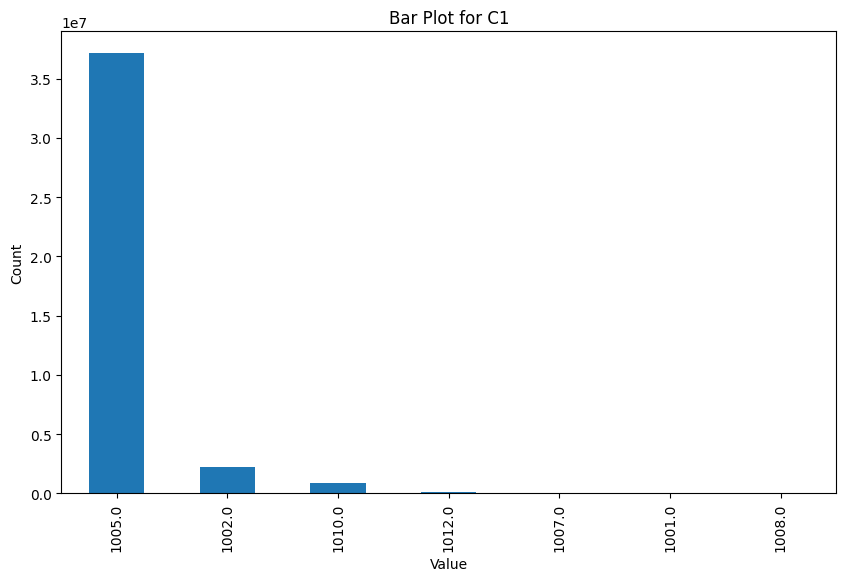

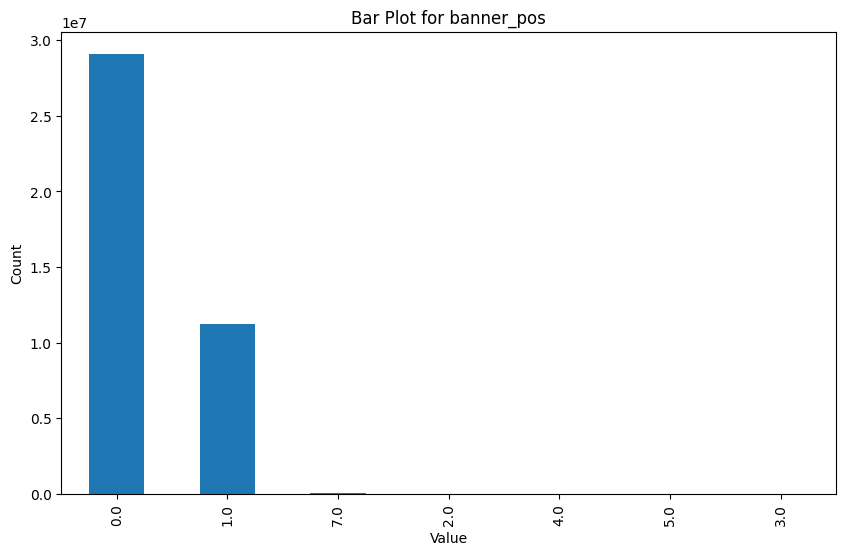

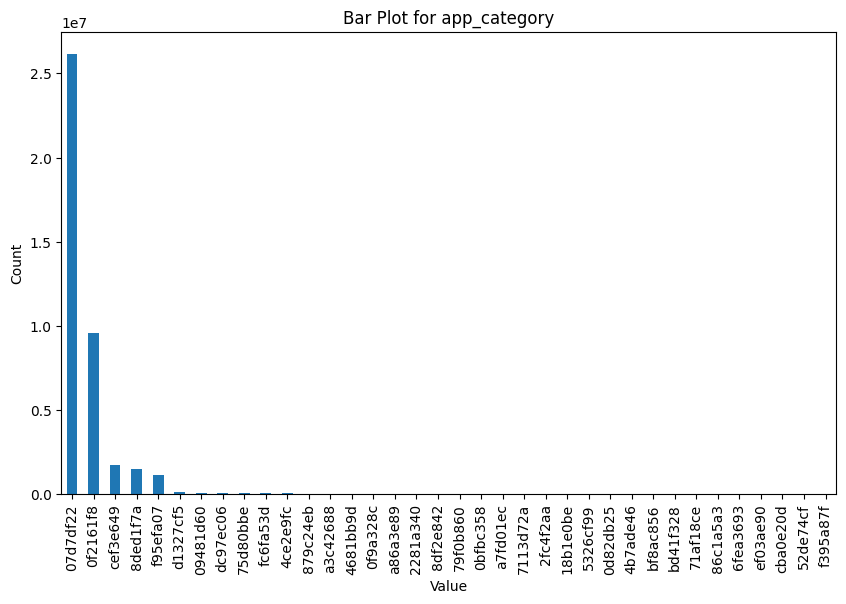

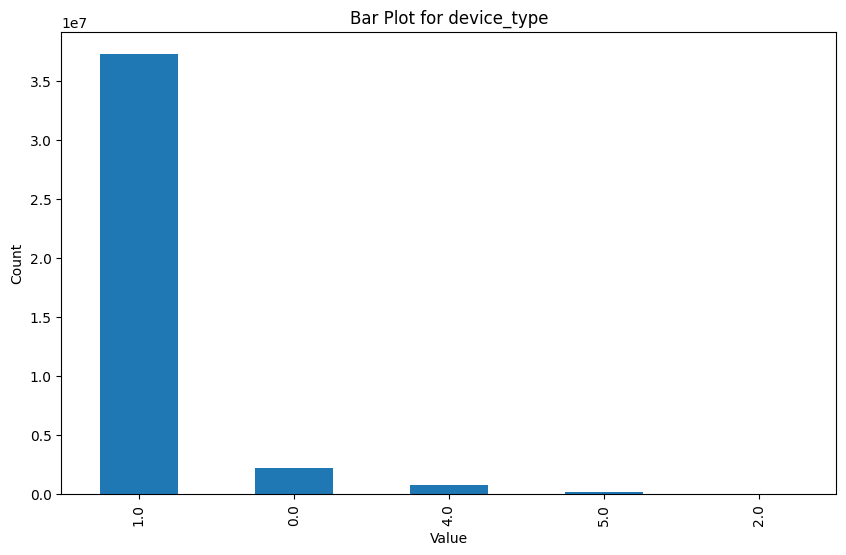

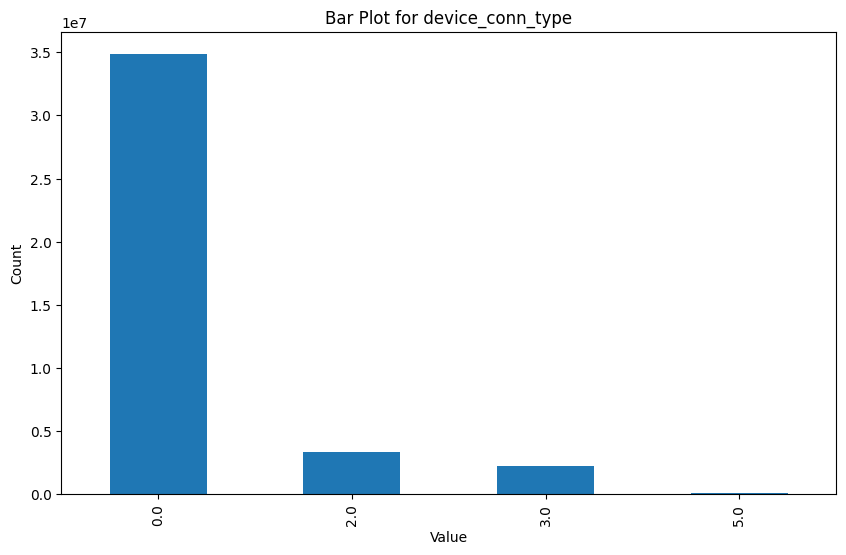

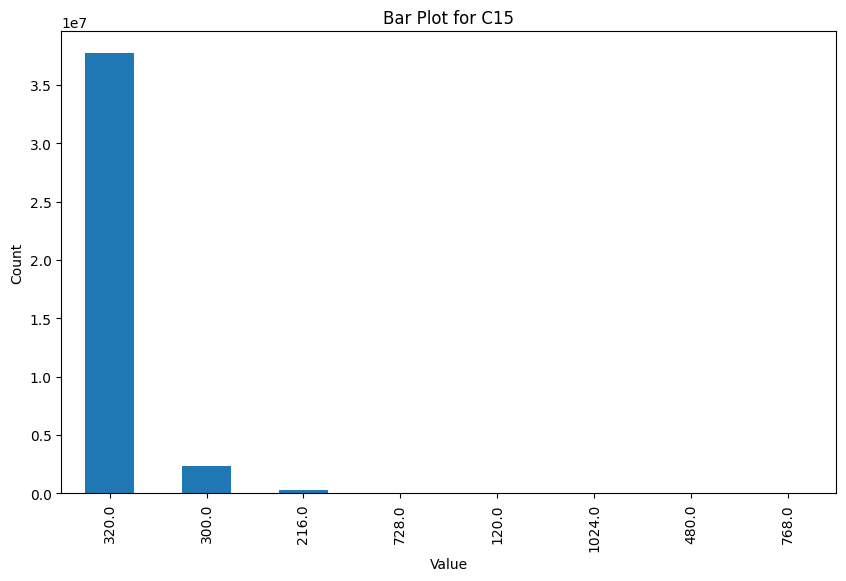

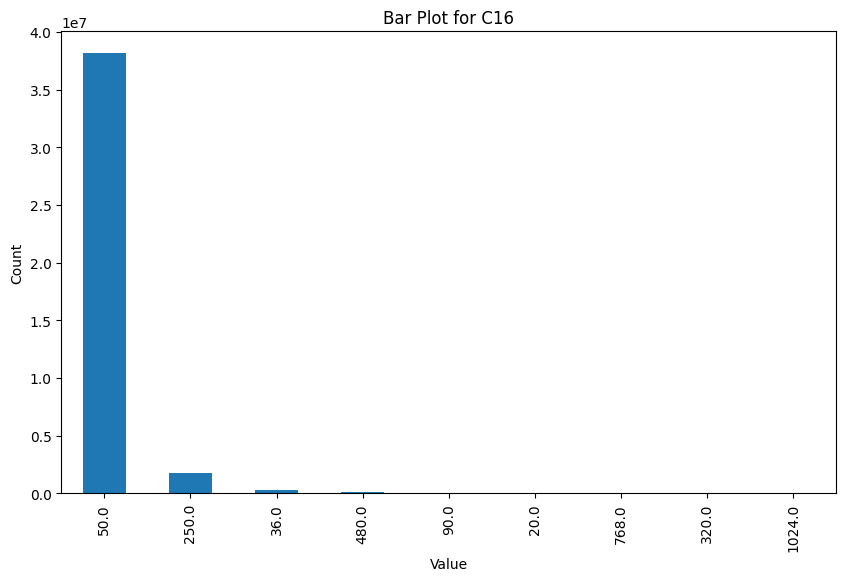

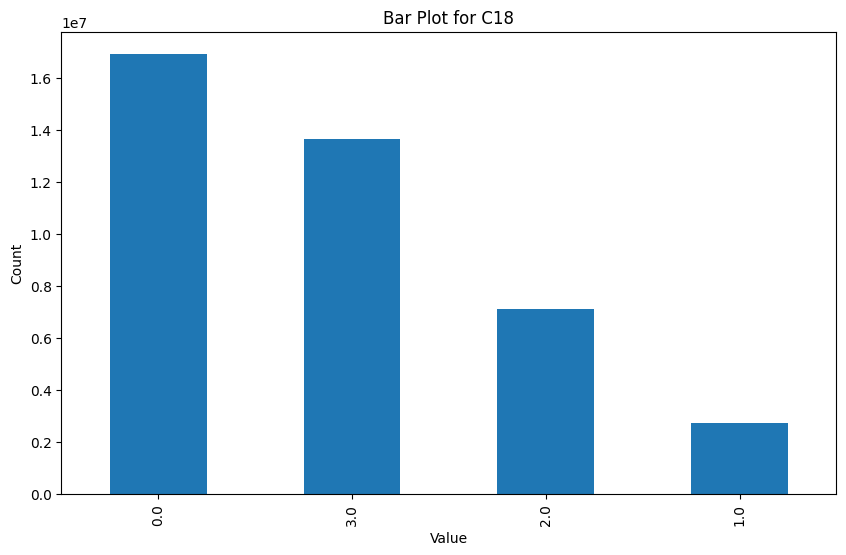

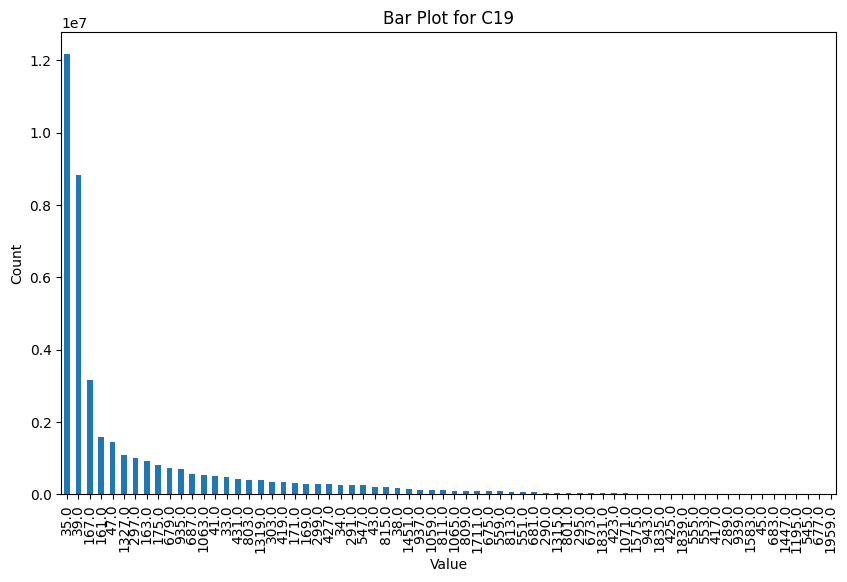

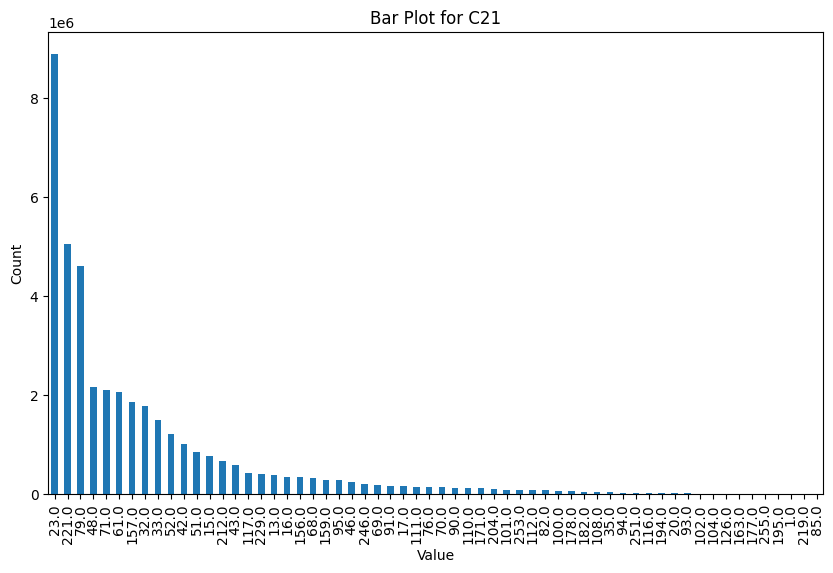

In [23]:
# Check and display unique values and their count of each the categorical columns
categorical_columns = ['C1', 'banner_pos','app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C19', 'C21']

for column in categorical_columns:
    # Compute the unique values and their counts
    unique_values = df[column].value_counts().compute()
    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    unique_values.plot(kind='bar')
    plt.title(f"Bar Plot for {column}")
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.show()

## Transforming Features

### Transforming Feature 'hour' into columns 'hour' and 'day_of_week'

In [38]:
# Convert 'hour' column to string
df['hour'] = df['hour'].astype(str)

In [40]:
from datetime import datetime

# Define a function to convert the 'hour' column to datetime and extract hour and day of the week
def process_hour(hour_str):
    try:
        hour_datetime = datetime.strptime(hour_str, "%y%m%d%H")
        hour = hour_datetime.hour
        day_of_week = hour_datetime.weekday()
        return hour, day_of_week
    except ValueError:
        return None, None  # Handle float values

# Apply the function to the 'hour' column using map_partitions
df['hour'], df['day_of_week'] = zip(*df['hour'].map(process_hour, meta=('int64', 'int64')))

# Display the DataFrame
print(df.head())

TypeError: strptime() argument 1 must be str, not float

# Encoding Categorical Data

In [ ]:
# Enconding the categorical variables
df = dd.get_dummies(df, columns=['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model','C14', 'C15' , 'C16' , 'C17' , 'C18' , 'C19' ,'C20', 'C21'])

# Dealing with Imbalanced Data

In [10]:
# Split the DataFrame into two separate DataFrames based on the click value
click_0 = df[df['click'] == 0]
click_1 = df[df['click'] == 1]

# Determine the number of rows in the minority class (click=1)
num_click_1 = click_1.shape[0].compute()

# Down-sample the majority class (click=0) to match the number of rows in the minority class (click=1)
click_0_downsampled = click_0.sample(frac=num_click_1 / click_0.shape[0].compute(), random_state=42)

# Combine the down-sampled majority class DataFrame with the original minority class DataFrame
df_downsampled = dd.concat([click_0_downsampled, click_1])

# Shuffle the DataFrame
df_downsampled = df_downsampled.sample(frac=1, random_state=42)

# Display the new value counts to verify downsampling
print("Down-sampled Click value counts:")
print(df_downsampled['click'].value_counts().compute())

Down-sampled Click value counts:
click
0.0    6865066
1.0    6865066
Name: count, dtype: int64


In [11]:
df_downsampled.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
99840,0.0,14102100.0,1005.0,0.0,5b08c53b,7687a86e,3e814130,ecad2386,7801e8d9,07d7df22,...,1.0,0.0,19015.0,300.0,250.0,2162.0,2.0,39.0,100224.0,33.0
171779,0.0,14102101.0,1005.0,0.0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,...,1.0,0.0,20362.0,320.0,50.0,2333.0,0.0,39.0,-1.0,157.0
378961,0.0,14102102.0,1005.0,0.0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1.0,0.0,15707.0,320.0,50.0,1722.0,0.0,35.0,-1.0,79.0
305710,0.0,14102102.0,1005.0,0.0,85f751fd,c4e18dd6,50e219e0,460f4063,d9b5648e,cef3e649,...,1.0,0.0,21611.0,320.0,50.0,2480.0,3.0,297.0,100111.0,61.0
67148,0.0,14102100.0,1005.0,0.0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1.0,0.0,15699.0,320.0,50.0,1722.0,0.0,35.0,100084.0,79.0


In [12]:
from dask_ml.model_selection import train_test_split

# Split the DataFrame into features (X) and target (y)
X = df_downsampled.drop(columns=['click'])
y = df_downsampled['click']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression

In [14]:
#!pip install dask-ml
from dask_ml.linear_model import LogisticRegression
from dask_ml.metrics import accuracy_score

# Initialize and fit the logistic regression model
lr = LogisticRegression(random_state=42)
lr.fit(X_train.values.compute(), y_train.values.compute())

# Predict on the test set
y_pred = lr.predict(X_test.values.compute())

# Compute the accuracy score
accuracy = accuracy_score(y_test.compute(), y_pred)

# Display the accuracy score
print("Accuracy Logistic Regression:", accuracy)

ValueError: could not convert string to float: '5b08c53b'